# Underfitting vs. Overfitting in Polynomial Regression

Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

## Overview

This example demonstrates the problems of underfitting and overfitting and how we can use linear regression with polynomial features to approximate nonlinear functions. The plot shows the function that we want to approximate, which is a part of the cosine function. In addition, the samples from the real function and the approximations of different models are displayed. The models have polynomial features of different degrees. We can see that a linear function (polynomial with degree 1) is not sufficient to fit the training samples. This is called **underfitting**. A polynomial of degree 4 approximates the true function almost perfectly. However, for higher degrees the model will **overfit** the training data, i.e. it learns the noise of the training data.
We evaluate quantitatively **overfitting** / **underfitting** by using cross-validation. We calculate the mean squared error (MSE) on the validation set, the higher, the less likely the model generalizes correctly from the training data.

## Libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.pipeline        import Pipeline
from sklearn.linear_model    import LinearRegression
from sklearn.preprocessing   import PolynomialFeatures

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error

## 1. Polynomial regression

Polynomial actually is a form of linear regression, because the resulting model is linear in the parameters, $\beta_i$. The difference is that we change the features into polynomials of the input data $x_i$,
$$
\hat y_i = \beta_0 + \beta_1\, x_i + \beta_2\, x_i^2 + \beta_3\, x_i^3 + \dots
$$
or in matrix form
$$
\begin{bmatrix} \hat y_1 \\ \hat y_2 \\ \vdots \\ \hat y_n \end{bmatrix} =
\begin{bmatrix}
   1 & x_1 & x_1^2 & x_1^3 & \dots \\
   1 & x_2 & x_2^2 & x_2^3 & \dots \\
   \vdots \\
   1 & x_n & x_n^2 & x_n^3 & \dots 
\end{bmatrix}
\begin{bmatrix}
   \beta_0 \\
   \beta_1 \\
   \beta_2 \\
   \beta_3 \\
   \vdots
\end{bmatrix}.
$$
$$
\hat{\bf y} = {\bf X}\, \beta.
$$

The coefficients, $\beta_i$, that minimize the cost function are given by the mean-squared error, MSE, and fullfill the normal equation:
$$
{\bf X}^\mathrm{T} {\bf X}\, \beta = {\bf X}^\mathrm{T}\, {\bf y}.
$$

### 1.1 Generate data

In [2]:
# Use a module to define the reference function used to generate the data
def reference_function(X):
    return np.cos(1.5 * np.pi * X)

# Define seed for reproducibility
np.random.seed(0)

# Define the number of samples and degrees for the polynomial
number_of_samples = 30
polynomial_degree = np.array([1, 4, 15])

# Generate random data for fitting
X = np.sort( np.random.rand(number_of_samples) )
y = reference_function(X) + 0.1*np.random.randn(number_of_samples)

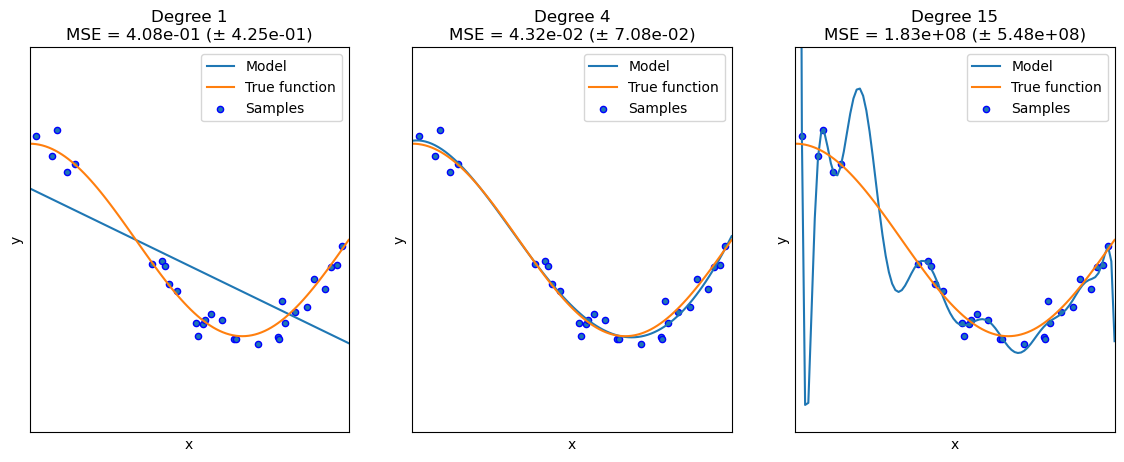

In [3]:
plt.figure( figsize=(14,5) )

for i in range(polynomial_degree.size):

    ax = plt.subplot(1, polynomial_degree.size, i+1)

    plt.setp( ax, xticks=(), yticks=() )

    plt.xlabel("x")
    plt.ylabel("y")

    plt.xlim( ( 0, 1) )
    plt.ylim( (-2, 2) )

    polynomial_features = PolynomialFeatures(degree=polynomial_degree[i], include_bias=False)
    linear_regression   = LinearRegression()

    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )

    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using cross-validation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)

    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")

    plt.plot(X_test, reference_function(X_test), label="True function")

    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")

    plt.title(f"Degree {polynomial_degree[i]}\n"
              f"MSE = {-scores.mean():.2e} (± {scores.std():.2e})")
    
    plt.legend(loc="best")

plt.show()

## 2. k-Fold cross validation

### Training and Testing Data
- Generally, we split data into training and testing sets.
- The training set is used to optimize the parameters of the model.
- The testing data is used to estimate the accuracy of the model on unseen data. 

### Validation Data
- Some models do not have sufficient flexibility to approximate the training data. These models have a high bias. They often perform similarly in the training and testing data.

- Sometimes models train well and have small loss on the training data, but perform poorly when presented with new data outside the training set. In this case the model has small bias but a large variance. This is known as overfitting to the training data.

- Many machine learning models have parameters that control their flexibility. An example is polynomial regression, where the order of the polynomial degree controls the flexibility and, hence, bias of the model.

- However, to decide what level of complexity is optimal for the machine learning model, we cannot use just the training data alone. We also cannot use the testing data as this would compromise its independence for estimating the accuracy of the model.

- Instead, we split data into a training and validation sets, where the training set is used to optimize the parameters of the model and the validation set then is used to compare between different models.

- In particular, k-fold cross validation is a technique for model selection where the training data set is divided into $k$ equal groups. The first group is considered as the validation set and the rest $k-1$ groups as training data, and the model is fit on it. This process is iteratively repeated $k-1$ times. Each time the $k^\mathrm{th}$ group will be selected as validation and the remaining $k-1$ groups be used for optimizing the model parameters, $\beta$. In each iteration, the validation MSE is calculated and the final MSE after $k$ iterations the Cross-Validation MSE is given as the average:
$$
\text{CV}_k = \frac{1}{N_k} \sum_{i=1}^k \text{MSE}_i
$$
This validation MSE is the estimate for our test data MSE.

<img src="https://github.com/rhennig/EMA6938/blob/main/Notebooks/Figures/Cross-Validation.png?raw=1" alt="Validation folds" align="center" style="width:400px; float:center"/>

Importantly, **cross-validation is for model selection or hyperparameter optimization** and utilizes the training data. To measure the **performance of our model**, we need to apply it to data that was not used in the optimization of the hyperparameters or model parameters. Usually, we keep a fraction of 20% of the data aside as a **holdout test set** and use 80% of the data for the training set used in cross-validations. We measure the model performance of the optimized model on the holdout test set.

Let's use the `KFold` object from the scikit-learn library to illustrate the indexes for a dataset are split into training and testing

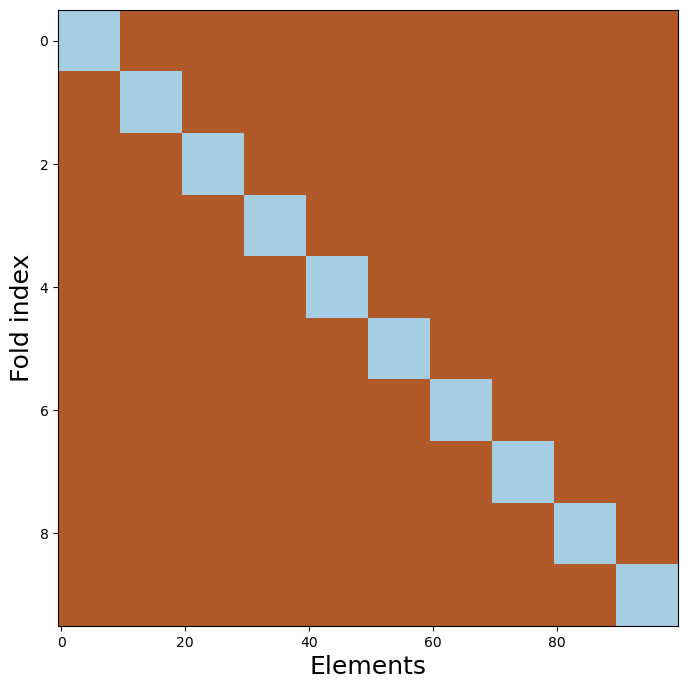

In [4]:
# Define a generic dataset
data_size = 100
k_folds   = 10

idx         = np.arange(data_size)
data_series = np.ones( (k_folds, data_size), dtype=float)

# Create the KFold object using 10 splits
k_folding = KFold(n_splits=k_folds)

for fold, (train, test) in enumerate( k_folding.split(idx) ):
    data_series[fold, test] = 0.0

# Plot the cross-validation indices for each fold
fig, ax = plt.subplots( figsize=(8,8) )

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

ax.set_xlabel('Elements',fontsize=18)
ax.set_ylabel('Fold index',fontsize=18)

plt.imshow(data_series, aspect='auto', cmap='Paired')

plt.show()

### 2.1 k-fold cross-validation in machine learning

In [5]:
# Define seed for reproducibility
np.random.seed(seed=0)

def reference_model(x, noise=False):

    y = np.cos(x) + 2.0*np.sin(x) + 3.0*np.cos(x*2)

    if noise:
        y = y + np.random.normal(0.0, 1.0, x.shape)

    return y

# Generate a reference data set without noise
x_ref = np.linspace(-0.3, 2.3, num=300)
y_ref = reference_model(x_ref, noise=False)

# Generate a data set with random noise
x = np.linspace(0.0, 2.0, num=300)
x = x + np.random.normal(0, 0.3, x.shape)

y = reference_model(x, noise=True)

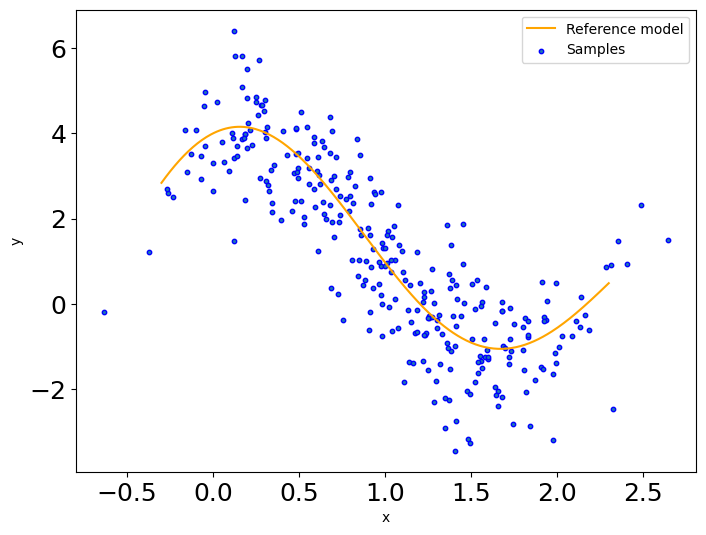

In [6]:
# Plot the  data set and the reference model

plt.figure( figsize=(8,6) )

plt.plot(x_ref, y_ref, color="orange", label="Reference model")
plt.scatter(x, y, edgecolor="b", s=10, label="Samples")

plt.xlabel("x")
plt.ylabel("y")

plt.legend(loc="best")

plt.show()

In [7]:
# Split the dataset into 80% for training and 20% for testing
x = x.reshape( (x.size,1) )
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

### 2.2 Select hyperparameters

First we need to evaluate the appropriate degree for the polynomial

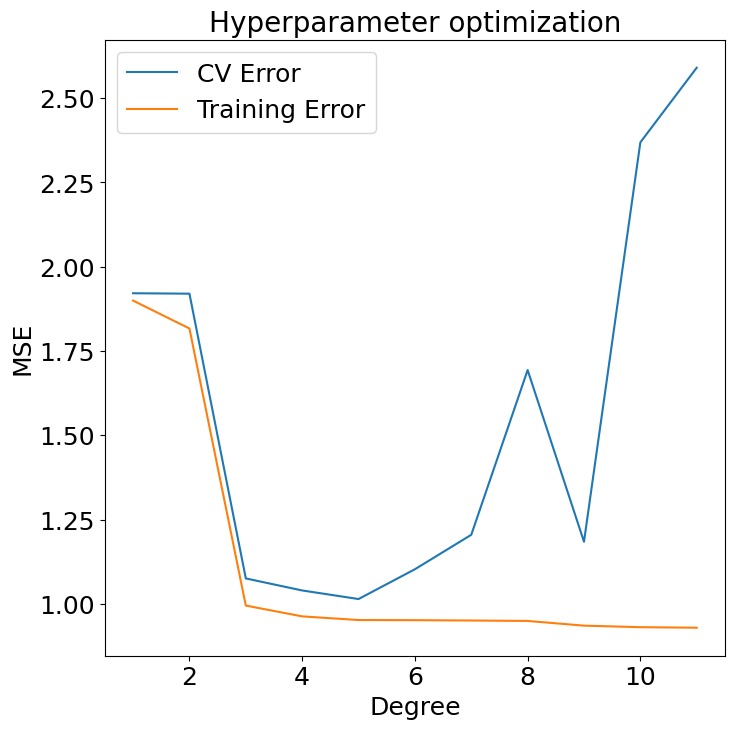

In [8]:
# Define the maximum degree of interest
polynomial_degrees = np.arange(start=1, stop=12, step=1)

# Define number of folds
number_of_folds    = 5

# Initialize empty lists to store the training and cross-validation errors
training_error_per_degree         = []
cross_validation_error_per_degree = []

for degree in polynomial_degrees:

    # Polynomial feature creation
    X = PolynomialFeatures(degree=degree).fit_transform(x_train)

    # Create regression model
    linear_regression = LinearRegression(fit_intercept=False)

    # Fit the model to the training data
    polynomial_model  = linear_regression.fit(X, y_train)

    y_train_pred      = polynomial_model.predict(X)

    training_mse      = mean_squared_error(y_train,y_train_pred)

    training_error_per_degree.append(training_mse)

    # Calculate the cross-validation MSE
    cross_validation_error = cross_validate(linear_regression, X, y_train,
                                            scoring='neg_mean_squared_error',
                                            cv=number_of_folds, return_train_score=True)

    mean_cross_validation_error = np.mean( np.absolute(cross_validation_error['test_score']) )

    cross_validation_error_per_degree.append(mean_cross_validation_error)

fig,ax=plt.subplots( figsize=(8,8) )

ax.set_xlabel('Degree', fontsize=18)
ax.set_ylabel('MSE',    fontsize=18)

ax.set_title('Hyperparameter optimization', fontsize=20)


ax.plot(polynomial_degrees, cross_validation_error_per_degree, label="CV Error")
ax.plot(polynomial_degrees, training_error_per_degree, label="Training Error")

ax.legend(loc='best', fontsize=18)

plt.show()

### 2.3 Validation with the holdout method

Now we use the best degree found in the previous section, then we train the model with the training set and validate it with the holdout set.

In [9]:
# Select the optimal hyperparameter
degree = np.argmin(cross_validation_error_per_degree) + 1
print(f"Optimal degree of polynomial regression = {degree}")

# Polynomial feature creation
X = PolynomialFeatures(degree=degree).fit_transform(x_train)

# Create regression model
linear_regression = LinearRegression(fit_intercept=False)

Optimal degree of polynomial regression = 5


In [10]:

# Fit the model to the training data
polynomial_model  = linear_regression.fit(X, y_train)

# Measure performance of optimal model on holdout dataset
X_test      = PolynomialFeatures(degree).fit_transform(x_test)

predicted_y = polynomial_model.predict(X_test)

mse_test    = mean_squared_error(y_test, predicted_y)

print(f"MSE on holdout set = {mse_test:.2f}")

# Calculate optimal polynomial regression
x_regression   = np.linspace(np.min(x), np.max(x), num=100)
x_regression_T = np.array([x_regression]).T
X_regression   = PolynomialFeatures(degree).fit_transform(x_regression_T)
y_model_pred   = linear_regression.predict(X_regression)

# Reference model
y_reference    = reference_model(x_regression, noise=False)

MSE on holdout set = 1.18


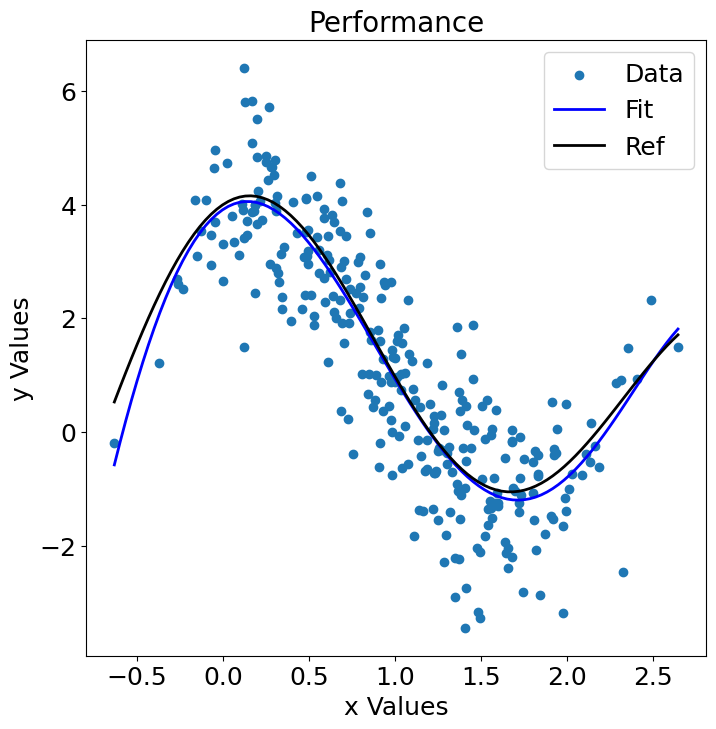

In [11]:

# Plot the whole dataset
fig, ax = plt.subplots( figsize=(8,8) )

ax.set_xlabel('x Values',   fontsize=18)
ax.set_ylabel('y Values',   fontsize=18)

ax.set_title('Performance', fontsize=20)

ax.scatter(x, y, label='Data')

ax.plot(x_regression, y_model_pred, color='b', label='Fit', lw=2)
ax.plot(x_regression, y_reference,  color='k', label='Ref', lw=2)

ax.legend(loc='best', fontsize=18)

plt.show()

> ### Assignment
>
> Visualize what happens when you set the degree of the polynomial to a one or a large number?

In [12]:
# Underfit model


# Overfit model


# Reference model


# Plot the whole dataset


## 3. Materials-motivated example: band gap bowing in a semiconductor alloy

A common materials-science task is to **predict a composition–property trend** from a *small* number of measurements or calculations.

As a concrete example, consider a **semiconductor alloy** where the band gap varies with composition, e.g. an alloy fraction $x\in[0,1]$ in something like $\mathrm{A}_{1-x}\mathrm{B}_x\mathrm{C}$.
A simple physically-motivated model is a **quadratic “bowing” curve**:

$$
E_g(x) = (1-x)E_g(0) + xE_g(1) - b\,x(1-x)
$$

where $b$ is the bowing parameter. In practice, data are noisy and sparse, and it's tempting to fit a very flexible model (high-degree polynomial) — which can **overfit**.

In this section we will:
1. Make a small synthetic (but materials-inspired) band gap dataset.
2. Show **overfitting** as we increase polynomial degree.
3. Use **k-fold cross-validation** to pick the polynomial degree.
4. Use **regularization** (Ridge / L2) to tame an over-parameterized model, and use cross-validation to pick the regularization strength.


In [13]:
# (Re)imports used in this section
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

# For reproducibility
rng = np.random.default_rng(42)


### 3.1 Generate a small (synthetic) alloy dataset

We'll sample a small number of alloy compositions \(x\) and generate noisy band gap values from a bowing curve.
Think of this like having only ~20–30 measured/calculated points across a composition range.


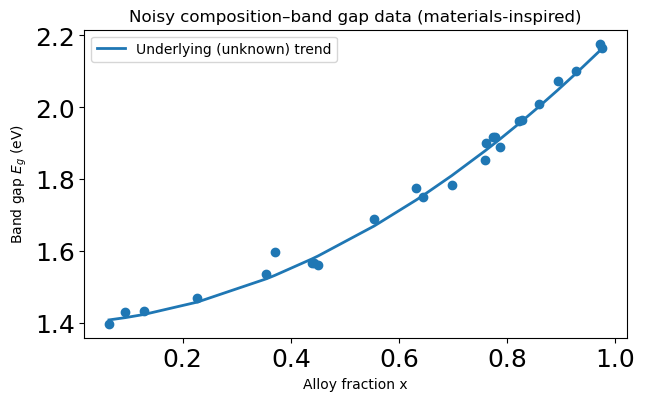

In [14]:
# Synthetic composition points (e.g., alloy fraction)
n_samples = 25
x_comp = np.sort(rng.random(n_samples))  # x in [0,1]
X_comp = x_comp.reshape(-1, 1)

# End-member band gaps (eV) and bowing parameter (eV) -- chosen for realism, not as exact values
Eg0, Eg1, bowing = 1.4, 2.2, 0.7

# "True" bowing curve + experimental / computational noise
Eg_true = (1 - x_comp) * Eg0 + x_comp * Eg1 - bowing * x_comp * (1 - x_comp)
Eg_measured = Eg_true + rng.normal(0, 0.03, size=n_samples)

plt.figure(figsize=(7,4))
plt.scatter(x_comp, Eg_measured)
plt.plot(x_comp, Eg_true, lw=2, label="Underlying (unknown) trend")
plt.xlabel("Alloy fraction x")
plt.ylabel("Band gap $E_g$ (eV)")
plt.title("Noisy composition–band gap data (materials-inspired)")
plt.legend()
plt.show()


### 3.2 Overfitting vs. polynomial degree (with k-fold cross-validation)

We'll fit polynomial regression models of increasing degree.

- **Training error** will almost always go down as degree increases.
- **Cross-validation error** will typically go down at first (model gets more flexible), then go up (model starts fitting noise / becomes numerically unstable).

That "U-shape" in CV error is the signature of overfitting.


Best degree by 5-fold CV (lowest mean CV MSE): 2


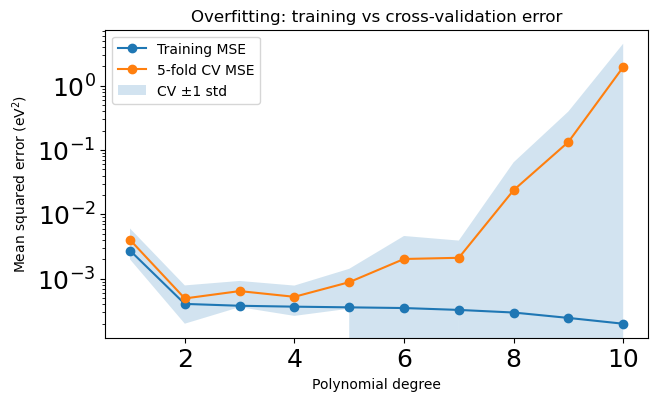

In [15]:
degrees = range(1, 11)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

train_mse = []
cv_mse = []
cv_std = []

for d in degrees:
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("linreg", LinearRegression()),
    ])
    scores = cross_validate(
        model,
        X_comp,
        Eg_measured,
        cv=kfold,
        scoring="neg_mean_squared_error",
        return_train_score=True
    )
    train_mse.append(-scores["train_score"].mean())
    cv_mse.append(-scores["test_score"].mean())
    cv_std.append(scores["test_score"].std())

best_degree = degrees[int(np.argmin(cv_mse))]
print(f"Best degree by 5-fold CV (lowest mean CV MSE): {best_degree}")

plt.figure(figsize=(7,4))
plt.plot(list(degrees), train_mse, marker="o", label="Training MSE")
plt.plot(list(degrees), cv_mse, marker="o", label="5-fold CV MSE")
plt.fill_between(
    list(degrees),
    np.array(cv_mse) - np.array(cv_std),
    np.array(cv_mse) + np.array(cv_std),
    alpha=0.2,
    label="CV ±1 std",
)
plt.yscale("log")  # makes the overfitting blow-up easier to see
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error (eV$^2$)")
plt.title("Overfitting: training vs cross-validation error")
plt.legend()
plt.show()


#### Visualizing the overfit curve

Let's compare:
- a **reasonable** model (degree picked by CV; often ~2 for bowing),
- a **high-degree** polynomial that can wiggle to chase noise.

In real materials modeling, a wildly oscillatory curve can imply unphysical behavior (e.g., negative band gaps).


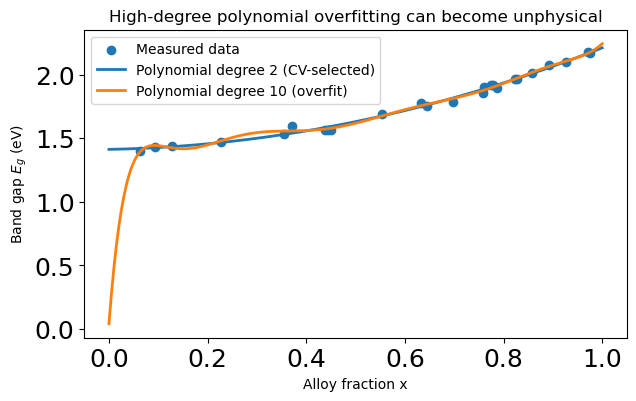

Overfit model predicted Eg range on [0,1]: 0.04 to 2.24 eV


In [16]:
x_grid = np.linspace(0, 1, 400).reshape(-1, 1)

# Fit the CV-selected degree model
model_best = Pipeline([
    ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
    ("linreg", LinearRegression()),
]).fit(X_comp, Eg_measured)

# Fit an intentionally high-degree model (over-parameterized)
degree_overfit = 10
model_overfit = Pipeline([
    ("poly", PolynomialFeatures(degree=degree_overfit, include_bias=False)),
    ("linreg", LinearRegression()),
]).fit(X_comp, Eg_measured)

Eg_pred_best = model_best.predict(x_grid)
Eg_pred_overfit = model_overfit.predict(x_grid)

plt.figure(figsize=(7,4))
plt.scatter(x_comp, Eg_measured, label="Measured data")
plt.plot(x_grid.ravel(), Eg_pred_best, lw=2, label=f"Polynomial degree {best_degree} (CV-selected)")
plt.plot(x_grid.ravel(), Eg_pred_overfit, lw=2, label=f"Polynomial degree {degree_overfit} (overfit)")
plt.xlabel("Alloy fraction x")
plt.ylabel("Band gap $E_g$ (eV)")
plt.title("High-degree polynomial overfitting can become unphysical")
plt.legend()
plt.show()

print(f"Overfit model predicted Eg range on [0,1]: {Eg_pred_overfit.min():.2f} to {Eg_pred_overfit.max():.2f} eV")


### 3.3 Regularization: Ridge (L2) regression to control an over-parameterized model

**Regularization** adds a penalty for large coefficients.

For Ridge regression, we minimize:

$$
\text{loss} = \sum_i (y_i - \hat{y}_i)^2 + \alpha\,\lVert \mathbf{w} \rVert_2^2
$$

- Large $\alpha$ forces coefficients to stay small (smoother curve, less variance).
- Small $\alpha$ behaves more like ordinary least squares (can overfit).

We'll keep the polynomial basis very flexible (degree 15) but use **cross-validation** to choose $\alpha$.


Best Ridge alpha by 5-fold CV: 0.00316


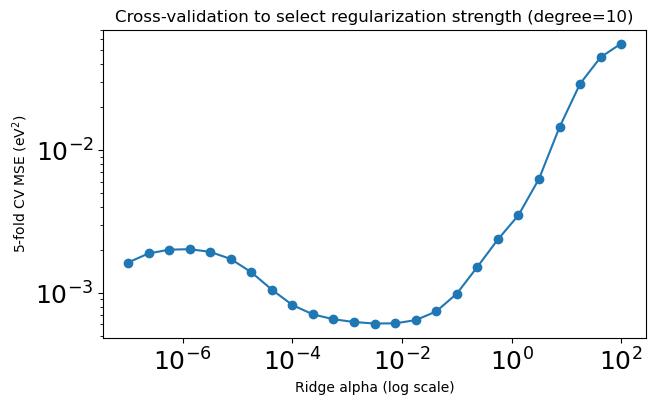

In [17]:
alphas = np.logspace(-7, 2, 25)

cv_mse_alpha = []
for a in alphas:
    ridge_model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree_overfit, include_bias=False)),
        ("ridge", Ridge(alpha=a)),
    ])
    scores = cross_val_score(
        ridge_model,
        X_comp,
        Eg_measured,
        cv=kfold,
        scoring="neg_mean_squared_error",
    )
    cv_mse_alpha.append(-scores.mean())

best_alpha = alphas[int(np.argmin(cv_mse_alpha))]
print(f"Best Ridge alpha by 5-fold CV: {best_alpha:.3g}")

plt.figure(figsize=(7,4))
plt.plot(alphas, cv_mse_alpha, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Ridge alpha (log scale)")
plt.ylabel("5-fold CV MSE (eV$^2$)")
plt.title(f"Cross-validation to select regularization strength (degree={degree_overfit})")
plt.show()


#### Ridge vs. unregularized fit (same polynomial degree)

Now compare two models with the *same* high-degree polynomial basis:
- **Unregularized** (LinearRegression): can produce huge coefficients and wild oscillations.
- **Ridge-regularized**: much more stable and smoother.

This is common in materials ML: you might use a rich feature set (many descriptors), but regularization prevents the model from “memorizing” noise.


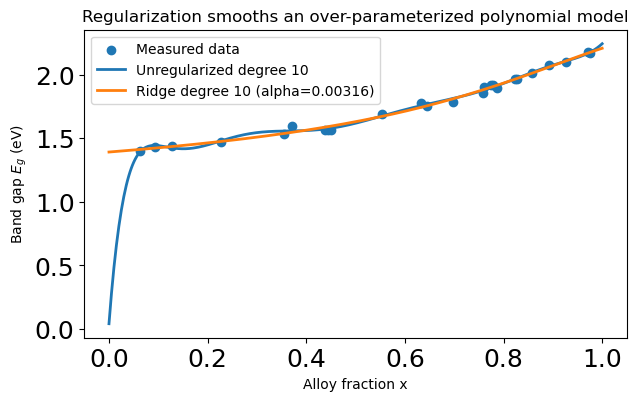

Max |coefficient| (unregularized): 118824.56272858201
Max |coefficient| (Ridge):         0.30913590420468207


In [18]:
# Fit Ridge model using the CV-selected alpha
model_ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=degree_overfit, include_bias=False)),
    ("ridge", Ridge(alpha=best_alpha)),
]).fit(X_comp, Eg_measured)

Eg_pred_ridge = model_ridge.predict(x_grid)

plt.figure(figsize=(7,4))
plt.scatter(x_comp, Eg_measured, label="Measured data")
plt.plot(x_grid.ravel(), Eg_pred_overfit, lw=2, label=f"Unregularized degree {degree_overfit}")
plt.plot(x_grid.ravel(), Eg_pred_ridge, lw=2, label=f"Ridge degree {degree_overfit} (alpha={best_alpha:.3g})")
plt.xlabel("Alloy fraction x")
plt.ylabel("Band gap $E_g$ (eV)")
plt.title("Regularization smooths an over-parameterized polynomial model")
plt.legend()
plt.show()

# Coefficient magnitude comparison (helps explain *why* Ridge is smoother)
poly = PolynomialFeatures(degree=degree_overfit, include_bias=False)
X_poly = poly.fit_transform(X_comp)

lin = LinearRegression().fit(X_poly, Eg_measured)
ridge = Ridge(alpha=best_alpha).fit(X_poly, Eg_measured)

print("Max |coefficient| (unregularized):", np.max(np.abs(lin.coef_)))
print("Max |coefficient| (Ridge):        ", np.max(np.abs(ridge.coef_)))


### 3.4 Regularization: Lasso (L1) for sparse, interpretable models

Ridge (L2) shrinks coefficients, but typically keeps **all** features in the model.
**Lasso (L1)** can drive some coefficients **exactly to zero**, which makes it useful for **feature selection** / **interpretability**.

In a real materials informatics workflow, you might use L1 regularization to identify which
physically-motivated descriptors (e.g., composition terms, ionic radii mismatch, electronegativity difference, coordination features, etc.)
actually contribute to a property model.

Here, we reuse the *same* high-degree polynomial basis (degree = `degree_overfit`) and let cross-validation choose the L1 strength.


Best Lasso alpha by 5-fold CV: 0.00272


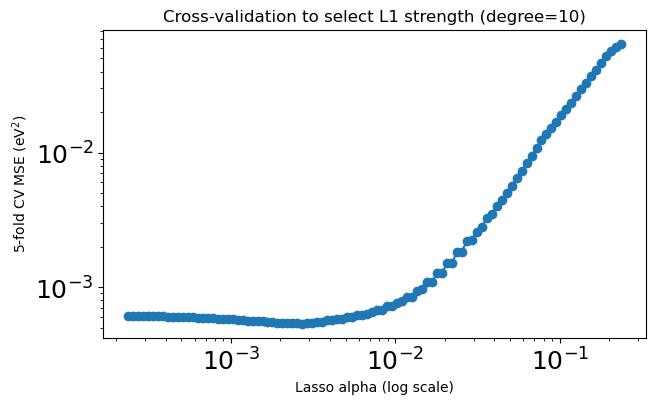

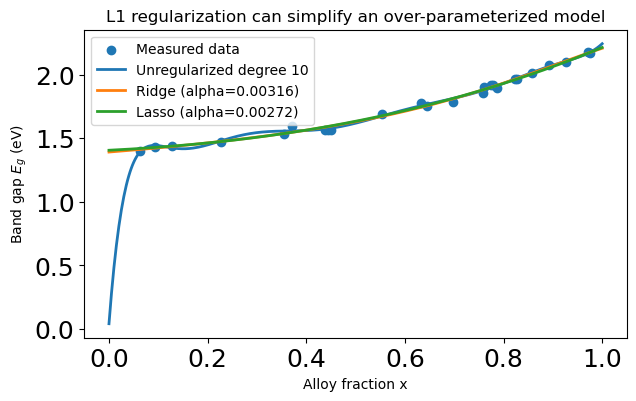

Non-zero polynomial terms: 3 / 10

Terms kept by Lasso (unscaled polynomial-feature basis):
     x: +0.1930
   x^2: +0.4359
   x^3: +0.1789


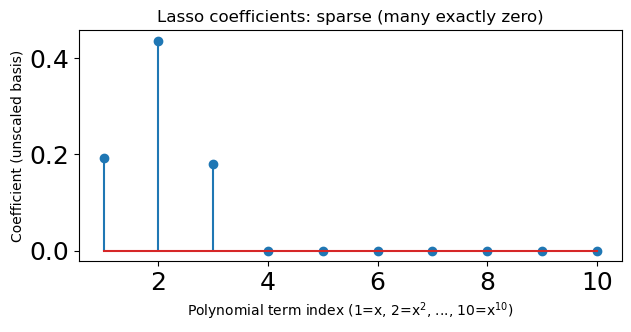

In [19]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Lasso is sensitive to feature scaling, so we standardize the polynomial features.
model_lasso_cv = Pipeline([
    ("poly", PolynomialFeatures(degree=degree_overfit, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=kfold, max_iter=200_000)),
]).fit(X_comp, Eg_measured)

best_alpha_l1 = model_lasso_cv.named_steps["lasso"].alpha_
print(f"Best Lasso alpha by 5-fold CV: {best_alpha_l1:.3g}")

# Plot CV MSE vs alpha (internal alpha grid chosen by LassoCV)
alphas_l1 = model_lasso_cv.named_steps["lasso"].alphas_
mse_path = model_lasso_cv.named_steps["lasso"].mse_path_   # shape: (n_alphas, n_folds)
mean_mse = mse_path.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(alphas_l1, mean_mse, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Lasso alpha (log scale)")
plt.ylabel("5-fold CV MSE (eV$^2$)")
plt.title(f"Cross-validation to select L1 strength (degree={degree_overfit})")
plt.show()

# Compare predictions of the overfit, Ridge, and Lasso models
Eg_pred_lasso = model_lasso_cv.predict(x_grid)

plt.figure(figsize=(7,4))
plt.scatter(x_comp, Eg_measured, label="Measured data")
plt.plot(x_grid.ravel(), Eg_pred_overfit, lw=2, label=f"Unregularized degree {degree_overfit}")
plt.plot(x_grid.ravel(), Eg_pred_ridge, lw=2, label=f"Ridge (alpha={best_alpha:.3g})")
plt.plot(x_grid.ravel(), Eg_pred_lasso, lw=2, label=f"Lasso (alpha={best_alpha_l1:.3g})")
plt.xlabel("Alloy fraction x")
plt.ylabel("Band gap $E_g$ (eV)")
plt.title("L1 regularization can simplify an over-parameterized model")
plt.legend()
plt.show()

# --- Which polynomial terms are "kept"? (non-zero coefficients) ---
poly = model_lasso_cv.named_steps["poly"]
scaler = model_lasso_cv.named_steps["scaler"]
lasso = model_lasso_cv.named_steps["lasso"]

feature_names = poly.get_feature_names_out(["x"])
coef_scaled = lasso.coef_

# Convert coefficients back to the *unscaled* polynomial-feature basis for interpretability:
# If X_scaled = (X - mean) / scale, then coef_unscaled = coef_scaled / scale.
coef_unscaled = coef_scaled / scaler.scale_

nonzero = np.abs(coef_unscaled) > 1e-8
print(f"Non-zero polynomial terms: {nonzero.sum()} / {len(coef_unscaled)}\n")

print("Terms kept by Lasso (unscaled polynomial-feature basis):")
for name, c in zip(feature_names, coef_unscaled):
    if abs(c) > 1e-8:
        print(f"  {name:>4s}: {c:+.4f}")

# Visualize sparsity: many coefficients are exactly zero
plt.figure(figsize=(7,3))
plt.stem(range(1, len(coef_unscaled)+1), coef_unscaled)
plt.xlabel("Polynomial term index (1=x, 2=x$^2$, ..., 10=x$^{10}$)")
plt.ylabel("Coefficient (unscaled basis)")
plt.title("Lasso coefficients: sparse (many exactly zero)")
plt.show()

# Note: if descriptors are strongly correlated, Lasso may pick one arbitrarily.
# In that case, ElasticNet (mix of L1+L2) is often more stable.


### 3.5 Takeaways for materials datasets

- **Small data is the norm** (expensive experiments, high-throughput DFT limits, etc.). High-capacity models can easily overfit.
- **Cross-validation** is a practical way to pick model complexity (polynomial degree, tree depth, NN size, etc.) without “peeking” at the test set.
- **Regularization** (Ridge/Lasso/ElasticNet, early stopping, dropout, etc.) is a way to use flexible models while controlling variance.
- **L1 regularization** (Lasso) can produce **sparse models** that highlight which descriptors/terms matter (coefficients exactly 0 vs non-zero).
- In real materials work, also watch out for **data leakage**:
  - repeated measurements of the same material,
  - multiple temperatures/pressures per composition,
  - train/test splits that accidentally put near-duplicates in both sets.

If you want an even more realistic extension, try replacing this synthetic dataset with a real one (e.g., formation energy, band gap, elastic moduli) and repeat the same CV + regularization workflow.